In [1]:
import os
import pandas as pd
import pandas_gbq
import pytz
import io
from dbfread import DBF

# Access Data in BigQuery

**Steps to Create a BigQuery API Key**:
- Go to Google Cloud Console
- Select Project in top drop down
- Select IAM & Admin in sidebar
- Select Service Accounts in sidebar
- Click Create Service Account button (example name bhereth-wfrcbq) 
- Create account and give permissions
- Select Keys option
- Clcik Add Key button - Create New Key
- Select JSON
- Should receive confirmation that key was created
- Look in 'Downloads' folder for key
- Move file to secure spot on local drive


In [9]:
# Link to BigQuery Client through API

#google cloud big query libaries
from google.cloud import bigquery
from google.oauth2 import service_account

key_path = r"C:\Users\bhereth\confidential-2023-utah-hts-db5335615978.json"
#key_path = r"C:\Users\bhereth\tdm-scenarios-a85044dbbfd3.json"

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id,)
print ('Successfully Linked to BigQuery Client!')

Successfully Linked to BigQuery Client!


In [44]:
# CRAFT SQL STATEMENT
# CAST function makes sure value returned is defined as int, to avoid weird precision issues with floats
# To get distances to 2-mile bins use FLOOR(distance_miles / 2) * 2 

strQry1 = """
SELECT 
  trip_type, 
  CAST(FLOOR(distance_miles / 2) * 2 AS INT64) AS distance_miles_2mibin,
  SUM(trip_weight) AS trip_weight_sum
FROM 
  `confidential-2023-utah-hts.20230313.ex_trip`
GROUP BY 
  trip_type, 
  distance_miles_2mibin
"""

In [27]:
# test connection
dfHouseholds = client.query("SELECT * FROM `confidential-2023-utah-hts.20230313.ex_hh`").to_dataframe()

display(dfHouseholds)

,hh_id,participation_group,is_complete,is_survey_complete,num_days_complete,num_days_survey_complete,num_days_complete_weekday,num_days_survey_complete_weekday,num_complete_mon,num_survey_complete_mon,...,bike_more_3,bike_more_4,bike_more_5,bike_more_6,bike_more_7,bike_more_8,bike_more_996,bike_more_997,bike_more_other,hh_weight
0,23064875,9,0,1,0,5,0,3,0,1,...,0,1,0,1,0,1,0,0,,0.000000
1,23075027,9,0,1,0,7,0,5,0,1,...,0,0,0,1,0,0,0,0,,0.000000
2,23089450,9,0,1,0,6,0,4,0,1,...,0,0,0,1,0,0,1,0,,0.000000
3,23106914,9,0,1,0,7,0,5,0,1,...,1,1,0,1,1,1,0,0,,0.000000
4,23129049,9,0,1,0,6,0,5,0,1,...,0,0,0,0,0,0,0,0,,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11178,23381104,9,1,1,7,7,5,5,1,1,...,1,0,1,0,0,0,0,0,,19.161332
11179,23384500,9,1,1,7,7,5,5,1,1,...,0,0,0,1,0,0,1,0,,589.566141
11180,23433444,9,1,1,7,7,5,5,1,1,...,0,0,0,1,1,0,0,0,,17.572443
11181,23461880,9,1,1,7,7,5,5,1,1,...,0,0,1,1,0,0,0,0,,11.448475


# Compare Trip Lengths by Trip Type

In [25]:
# DOESN'T WORK YET WITH TRIP TABLE
# AWAITING GLOBBING

# ACCESS DATA THROUGH BIGQUERY API
#dfBinnedTripDistance = client.query(strQry1).to_dataframe()

# USE TEMP CSV FROM GBQ BROWSER DOWNLOAD
dfBinnedTripDistance = pd.read_csv('bquxjob_1b1667df_18f06fb53f5.csv')

display(dfBinnedTripDistance)

,trip_type,distance_miles_2mibin,trip_weight_sum
0,7,10.0,46195.137161
1,995,46.0,2261.263668
2,995,8.0,87067.486697
3,995,12.0,65551.806063
4,995,10.0,65012.886309
...,...,...,...
969,6,838.0,0.000000
970,995,5014.0,113.350987
971,7,254.0,0.000000
972,5,120.0,0.000000


In [26]:
# import value labels to get description of codes
dfValueLabels = pd.read_csv('value_labels.csv')

display(dfValueLabels)

,table,variable,value,label
0,hh,participation_group,1,"Signup survey completed via browserMove, Diary..."
1,hh,participation_group,2,"Signup survey completed via browserMove, Diary..."
2,hh,participation_group,3,"Signup survey completed via browserMove, Diary..."
3,hh,participation_group,4,"Signup survey completed via call center, Diary..."
4,hh,participation_group,5,"Signup survey completed via call center, Diary..."
...,...,...,...,...
2036,trip,imputed_record_type,1,Imputed from proxy
2037,trip,imputed_record_type,2,Imputed school trip from attendance (no host t...
2038,trip,trace_quality_flag,0,No
2039,trip,trace_quality_flag,1,Yes


In [23]:
# Filter to just the trip type labels
# read in code labels and filter and clean up for just trip_type and cast as int64
dfTripTypeLabels = dfValueLabels[dfValueLabels['variable']=='trip_type'].copy()
dfTripTypeLabels.rename(columns={'value':'trip_type'}, inplace=True)
dfTripTypeLabels['trip_type'] = dfTripTypeLabels['trip_type'].astype('int64')
dfTripTypeLabels['Trip Type'] = dfTripTypeLabels['trip_type'].astype('str') + '-' + dfTripTypeLabels['label']
dfTripTypeLabels.drop(columns=['table','variable','label'], inplace=True)
dfTripTypeLabels

,trip_type,Trip Type
1890,1,1-Home-based work
1891,2,2-Home-based school
1892,3,3-Home-based shopping
1893,4,4-Home-based personal business
1894,5,5-Home-based other
1895,6,6-Non-home-based work
1896,7,7-Non-home-based non-work
1897,995,995-Missing response


In [29]:
# add labels onto data
dfBinnedTripDistance = pd.merge(dfBinnedTripDistance, dfTripTypeLabels, on='trip_type')
dfBinnedTripDistance

,trip_type,distance_miles_2mibin,trip_weight_sum,Trip Type
0,7,10.0,46195.137161,7-Non-home-based non-work
1,7,8.0,76585.100138,7-Non-home-based non-work
2,7,0.0,637360.929566,7-Non-home-based non-work
3,7,2.0,378611.422226,7-Non-home-based non-work
4,7,12.0,59553.198315,7-Non-home-based non-work
...,...,...,...,...
969,2,126.0,0.000000,2-Home-based school
970,2,84.0,44.142885,2-Home-based school
971,2,1146.0,17.986077,2-Home-based school
972,2,56.0,2.586812,2-Home-based school


## Calculate Distribution of Trips

In [170]:
# Group by 'trip_type' and 'distance_miles_2mibin' and sum 'trip_weight_sum'
grouped = dfBinnedTripDistance.groupby(['Trip Type', 'distance_miles_2mibin']).agg({'trip_weight_sum': 'sum'}).reset_index()

# Calculate the total weight for each trip type
total_weights = grouped.groupby('Trip Type')['trip_weight_sum'].transform('sum')

# Calculate percentage distribution
grouped['percentage'] = (grouped['trip_weight_sum'] / total_weights) * 100

# only plot below 60 miles
#filtered_grouped = grouped[grouped['distance_miles_2mibin'] <= 30].copy()


In [171]:
# Add cumulative distribution

# Assuming 'filtered_grouped' is a DataFrame that has been grouped appropriately
filtered_grouped['cumulative_percentage'] = filtered_grouped.groupby('Trip Type')['percentage'].cumsum()

## Plot distributions

### Seaborn Plot

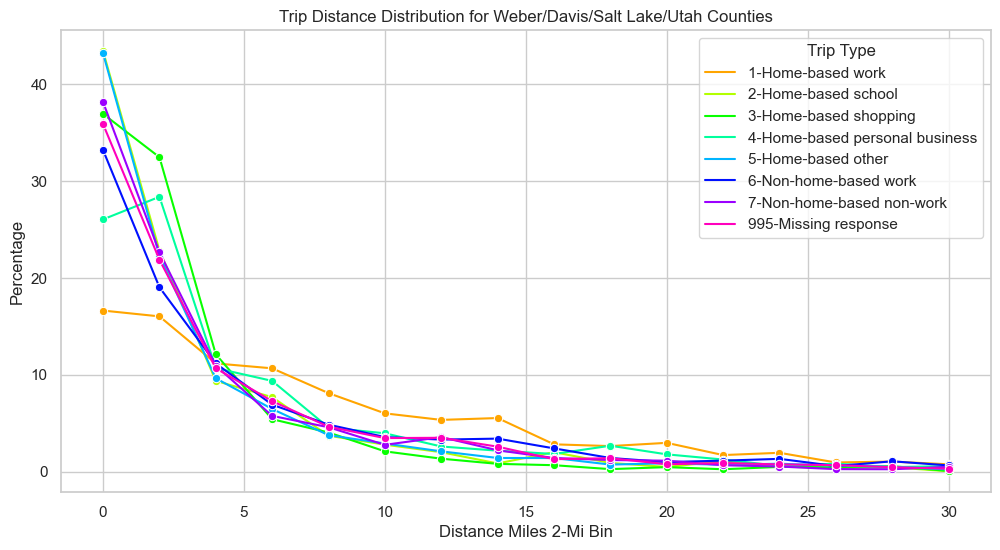

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plotting style
sns.set(style="whitegrid")

# Define a colorful palette
palette = sns.color_palette("hsv", n_colors=filtered_grouped['Trip Type'].nunique())

# Create the line plot
plt.figure(figsize=(12, 6))
# Filter to only include bins up to 100 miles for visualization
line_plot = sns.lineplot(data=filtered_grouped, x='distance_miles_2mibin', y='percentage', hue='Trip Type', marker='o', palette=palette)

# Set labels, title, and limits
plt.xlabel('Distance Miles 2-Mi Bin')
plt.ylabel('Percentage')
plt.title('Trip Distance Distribution for Weber/Davis/Salt Lake/Utah Counties')
plt.legend(title='Trip Type')

# Show the plot
plt.show()


### Plotly

In [173]:
import plotly.express as px

# Create an interactive line graph
fig = px.line(
    filtered_grouped,
    x='distance_miles_2mibin',
    y='percentage',
    color='Trip Type',
    #markers=True,  # This adds markers to each point
    labels={
        'distance_miles_2mibin': 'Distance Traveled (miles)',
        'percentage': 'Percentage'
    },
    title='Trip Distance Distribution for Weber/Davis/Salt Lake/Utah Counties'
    
)

# Update layout if necessary
fig.update_layout(
    xaxis_title='Distance Traveled (miles)',
    yaxis_title='Percentage of Trips',
    legend_title='Trip Type'
)

# Show the plot
fig.show()

### Seaborn Cumulative

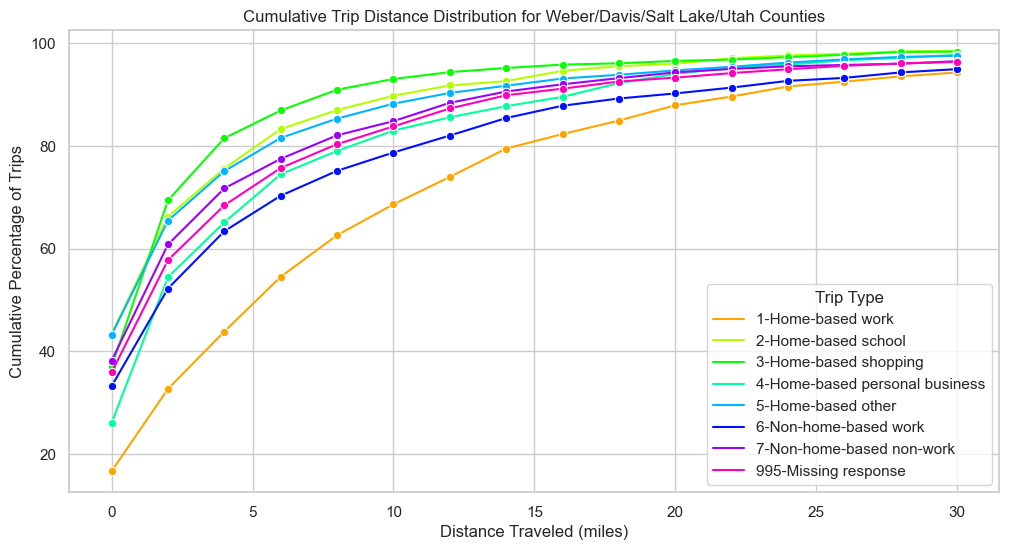

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plotting style
sns.set(style="whitegrid")

# Create the line plot with seaborn
plt.figure(figsize=(12, 6))
line_plot = sns.lineplot(
    data=filtered_grouped,
    x='distance_miles_2mibin',
    y='cumulative_percentage',
    hue='Trip Type',
    marker='o',
    palette=palette  # A perceptually uniform colormap
)

# Customize the plot with labels and titles
plt.xlabel('Distance Traveled (miles)')
plt.ylabel('Cumulative Percentage of Trips')
plt.title('Cumulative Trip Distance Distribution for Weber/Davis/Salt Lake/Utah Counties')
plt.legend(title='Trip Type')

# Show the plot
plt.show()


### Plotly Cumulative Distribution

In [175]:
import plotly.express as px

# Create an interactive line graph for cumulative distribution
fig = px.line(
    filtered_grouped,
    x='distance_miles_2mibin',
    y='cumulative_percentage',
    color='Trip Type',
    labels={
        'distance_miles_2mibin': 'Distance Traveled (miles)',
        'cumulative_percentage': 'Cumulative Percentage'
    },
    title='Cumulative Trip Distance Distribution for Weber/Davis/Salt Lake/Utah Counties'
)

# Update layout if necessary
fig.update_layout(
    xaxis_title='Distance Traveled (miles)',
    yaxis_title='Cumulative Percentage of Trips',
    legend_title='Trip Type'
)

# Show the plot
fig.show()


# Compare HBW distribution by Income

In [176]:
# CRAFT SQL STATEMENT
# CAST function makes sure value returned is defined as int, to avoid weird precision issues with floats
# To get distances to 2-mile bins use FLOOR(distance_miles / 2) * 2
# JOIN trip and hh tables on hh_id

strQry2 = """
SELECT 
  trip.trip_type, 
  CAST(FLOOR(trip.distance_miles / 2) * 2 AS INT64) AS distance_miles_2mibin,
  hh.income_detailed,
  SUM(trip.trip_weight) AS trip_weight_sum
FROM 
  `confidential-2023-utah-hts.20230313.ex_trip` AS trip
JOIN
  `confidential-2023-utah-hts.20230313.ex_hh` AS hh
ON 
  trip.hh_id = hh.hh_id
GROUP BY 
  trip.trip_type, 
  distance_miles_2mibin,
  hh.income_detailed
"""

In [177]:
# DOESN'T WORK YET WITH TRIP TABLE
# AWAITING GLOBBING

# ACCESS DATA THROUGH BIGQUERY API
#dfBinnedTripDistance = client.query(strQry2).to_dataframe()

# USE TEMP CSV FROM GBQ BROWSER DOWNLOAD
dfBinnedTripDistanceAndIncome = pd.read_csv('bquxjob_3731317a_18f075026b8.csv')

display(dfBinnedTripDistanceAndIncome)

,trip_type,distance_miles_2mibin,income_detailed,trip_weight_sum
0,995,6.0,5,22627.231686
1,3,8.0,5,9318.391152
2,3,36.0,5,84.120228
3,7,10.0,5,8848.344359
4,995,46.0,5,947.320862
...,...,...,...,...
5143,6,70.0,4,0.000000
5144,5,120.0,2,0.000000
5145,6,1230.0,7,0.000000
5146,1,90.0,8,13.497803


In [178]:
# Assuming dfValueLabels is your DataFrame loaded with necessary data including 'variable', 'value', 'label', etc.

# Filter to just the income type labels
dfIncomeLabels = dfValueLabels[dfValueLabels['variable'] == 'income_detailed'].copy()

# Rename columns as needed and ensure 'income_detailed' is cast as int64
dfIncomeLabels.rename(columns={'value': 'income_detailed'}, inplace=True)
dfIncomeLabels['income_detailed'] = dfIncomeLabels['income_detailed'].astype('int64')

# Create a new 'Income' column combining the 'income_detailed' and 'label' columns
dfIncomeLabels['Income'] = dfIncomeLabels['income_detailed'].astype('str') + '-' + dfIncomeLabels['label']

# Drop unnecessary columns
dfIncomeLabels.drop(columns=['table', 'variable', 'label'], inplace=True)

# Extract unique income bins
income_bins = dfIncomeLabels['Income'].unique()

# Create a list of tuples with formatted display values, original values, and income_detailed
options = [(f"{int(bin.split('-')[0]):03}-{bin.split('-', 1)[1]}", bin, int(bin.split('-')[0])) for bin in income_bins]

# Sort the options based on the formatted (display) part, which is the first element of each tuple
options.sort(key=lambda x: x[0])

# Create a DataFrame with options including 'income_detailed'
dfIncomeLabels = pd.DataFrame(options, columns=['Income', 'Original', 'income_detailed'])

# Display or return dfIncomeLabels
dfIncomeLabels = dfIncomeLabels[['income_detailed','Income']]
dfIncomeLabels


,income_detailed,Income
0,1,"001-Less than $15,000"
1,2,"002-$15,000-$24,999"
2,3,"003-$25,000-$34,999"
3,4,"004-$35,000-$49,999"
4,5,"005-$50,000-$74,999"
5,6,"006-$75,000-$99,999"
6,7,"007-$100,000-$149,999"
7,8,"008-$150,000-$199,999"
8,9,"009-$200,000-$249,999"
9,10,"010-$250,000 or more"


In [179]:
# add labels onto data
dfBinnedTripDistanceAndIncome = pd.merge(dfBinnedTripDistanceAndIncome, dfTripTypeLabels, on='trip_type')
dfBinnedTripDistanceAndIncome = pd.merge(dfBinnedTripDistanceAndIncome, dfIncomeLabels, on='income_detailed')
dfBinnedTripDistanceAndIncome

,trip_type,distance_miles_2mibin,income_detailed,trip_weight_sum,Trip Type,Income
0,995,6.0,5,22627.231686,995-Missing response,"005-$50,000-$74,999"
1,995,46.0,5,947.320862,995-Missing response,"005-$50,000-$74,999"
2,995,8.0,5,20901.566540,995-Missing response,"005-$50,000-$74,999"
3,995,12.0,5,11202.574912,995-Missing response,"005-$50,000-$74,999"
4,995,10.0,5,8981.550640,995-Missing response,"005-$50,000-$74,999"
...,...,...,...,...,...,...
5143,2,10.0,3,469.113878,2-Home-based school,"003-$25,000-$34,999"
5144,2,22.0,3,37.056990,2-Home-based school,"003-$25,000-$34,999"
5145,2,20.0,3,37.056990,2-Home-based school,"003-$25,000-$34,999"
5146,2,54.0,3,2.786011,2-Home-based school,"003-$25,000-$34,999"


In [180]:
# Group by 'trip_type' and 'distance_miles_2mibin' and sum 'trip_weight_sum'
groupedIncome = dfBinnedTripDistanceAndIncome.groupby(['Trip Type', 'distance_miles_2mibin','Income']).agg({'trip_weight_sum': 'sum'}).reset_index()

# Calculate the total weight for each trip type
total_weights = groupedIncome.groupby(['Trip Type','Income'])['trip_weight_sum'].transform('sum')

# Calculate percentage distribution
groupedIncome['percentage'] = (groupedIncome['trip_weight_sum'] / total_weights) * 100

# only plot below 60 miles
filtered_groupedIncome = groupedIncome[groupedIncome['distance_miles_2mibin'] <= 60].copy()

display(filtered_groupedIncome)


,Trip Type,distance_miles_2mibin,Income,trip_weight_sum,percentage
0,1-Home-based work,0.0,"001-Less than $15,000",11363.493723,44.636551
1,1-Home-based work,0.0,"002-$15,000-$24,999",12092.779402,32.038777
2,1-Home-based work,0.0,"003-$25,000-$34,999",26935.723346,37.970377
3,1-Home-based work,0.0,"004-$35,000-$49,999",17451.691694,17.791789
4,1-Home-based work,0.0,"005-$50,000-$74,999",34378.930452,16.240522
...,...,...,...,...,...
4419,995-Missing response,60.0,"006-$75,000-$99,999",90.527638,0.019338
4420,995-Missing response,60.0,"007-$100,000-$149,999",227.634725,0.034434
4421,995-Missing response,60.0,"008-$150,000-$199,999",877.461109,0.328169
4422,995-Missing response,60.0,"009-$200,000-$249,999",1082.011139,0.547218


In [181]:
# Add cumulative distribution

# Assuming 'filtered_grouped' is a DataFrame that has been grouped appropriately
filtered_groupedIncome['cumulative_percentage'] = filtered_groupedIncome.groupby(['Trip Type','Income'])['percentage'].cumsum()
display(filtered_groupedIncome)

,Trip Type,distance_miles_2mibin,Income,trip_weight_sum,percentage,cumulative_percentage
0,1-Home-based work,0.0,"001-Less than $15,000",11363.493723,44.636551,44.636551
1,1-Home-based work,0.0,"002-$15,000-$24,999",12092.779402,32.038777,32.038777
2,1-Home-based work,0.0,"003-$25,000-$34,999",26935.723346,37.970377,37.970377
3,1-Home-based work,0.0,"004-$35,000-$49,999",17451.691694,17.791789,17.791789
4,1-Home-based work,0.0,"005-$50,000-$74,999",34378.930452,16.240522,16.240522
...,...,...,...,...,...,...
4419,995-Missing response,60.0,"006-$75,000-$99,999",90.527638,0.019338,98.652145
4420,995-Missing response,60.0,"007-$100,000-$149,999",227.634725,0.034434,99.116023
4421,995-Missing response,60.0,"008-$150,000-$199,999",877.461109,0.328169,98.766241
4422,995-Missing response,60.0,"009-$200,000-$249,999",1082.011139,0.547218,95.083539


In [182]:
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, Markdown

# Function to update the plot based on selected income bin
def update_plot(income_bin):

    output.clear_output()

    global firstTime
    if firstTime:
        firstTime = False
    else:

        filtered_data = filtered_groupedIncome[filtered_groupedIncome['Income'] == income_bin]
        fig = px.line(
            filtered_data,
            x='distance_miles_2mibin',
            y='cumulative_percentage',
            color='Trip Type',
            labels={
                'distance_miles_2mibin': 'Distance Traveled (miles)',
                'cumulative_percentage': 'Cumulative Percentage'
            },
            title=f'Cumulative Trip Distance Distribution for Income {income_bin}'
        )
        fig.update_layout(
            xaxis_title='Distance Traveled (miles)',
            yaxis_title='Cumulative Percentage of Trips',
            legend_title='Trip Type'
        )
        fig.show()
        
# Define widgets and output
income_bins = filtered_groupedIncome['Income'].unique()
dropdown = widgets.Dropdown(
    options=income_bins,
    description='Select Income:',
    disabled=False,
)

# Set up a global variable to track whether the widgets have been changed
firstTime = True

# create output widget to display filtered DataFrame
output = widgets.Output()

# create interactive widget
interactive_output = widgets.interactive_output(update_plot, {'income_bin': dropdown})


# Widget interaction

# Display a markdown heading
display(Markdown('# Distribution by Income'))
display(dropdown)
display(interactive_output)
display(output)

# Distribution by Income

Dropdown(description='Select Income:', options=('001-Less than $15,000', '002-$15,000-$24,999', '003-$25,000-$…

Output()

Output()

In [190]:
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output

# Assuming 'filtered_groupedIncome' is defined and contains 'Trip Type' and 'Income' columns

color_map = {
    '001-Less than $15,000'   :'#B6E0FE',
    '002-$15,000-$24,999'     :'#92C5FC',
    '003-$25,000-$34,999'     :'#6FA8DC',
    '004-$35,000-$49,999'     :'#4D85BD',
    '005-$50,000-$74,999'     :'#357ABD',
    '006-$75,000-$99,999'     :'#2B6CB0',
    '007-$100,000-$149,999'   :'#2A4B8D',
    '008-$150,000-$199,999'   :'#1E3A5F',
    '009-$200,000-$249,999'   :'#162447',
    '010-$250,000 or more'    :'#0A2239',
    '999-Prefer not to answer':'#eeeeee' 
}


# Function to update the plot based on selected income and trip types
def update_plot(income_bin, triptype):

    output.clear_output()

    global firstTime
    if firstTime:
        firstTime = False
    else:
        # Filter data based on the selected income and trip types
        filtered_data = filtered_groupedIncome[
            (filtered_groupedIncome['Income'].isin(income_bin) &
            (filtered_groupedIncome['Trip Type'] == triptype))
        ]
        fig = px.line(
            filtered_data,
            x='distance_miles_2mibin',
            y='cumulative_percentage',
            color='Income',
            color_discrete_map=color_map,  # Map specific colors to categories
            labels={
                'distance_miles_2mibin': 'Distance Traveled (miles)',
                'cumulative_percentage': 'Cumulative Percentage'
            },
            title=f'Cumulative Trip Distance Distribution for Income {income_bin}'

        )
        fig.update_layout(
            xaxis_title='Distance Traveled (miles)',
            yaxis_title='Cumulative Percentage of Trips',
            legend_title='Trip Type'
        )
        fig.show()

# Extract unique values for income bins and trip types
income_bins = filtered_groupedIncome['Income'].unique()
trip_types = filtered_groupedIncome['Trip Type'].unique()

# Create dropdown for income bin selection
income_dropdown = widgets.SelectMultiple(
    options=income_bins,
    description='Select Income:',
    disabled=False,
)

# Create multiselect for trip types
trip_type_selector = widgets.Dropdown(
    options=trip_types,
    description='Trip Types:',
    disabled=False
)

# Set up a global variable to track whether the widgets have been changed
firstTime = True


# create output widget to display filtered DataFrame
output = widgets.Output()

# create interactive widget
interactive_output = widgets.interactive_output(update_plot, {'income_bin': income_dropdown, 'triptype': trip_type_selector})
# Display widgets and output
display(Markdown('# Distribution by Income and Trip Type'))
display(income_dropdown)
display(trip_type_selector)
display(interactive_output)
display(output)


# Distribution by Income and Trip Type

SelectMultiple(description='Select Income:', options=('001-Less than $15,000', '002-$15,000-$24,999', '003-$25…

Dropdown(description='Trip Types:', options=('1-Home-based work', '2-Home-based school', '3-Home-based shoppin…

Output()

Output()